This notebook is an analysis demonstrating the use of multiomics data to distinguish cell states/types using Scanpy for snRNA-seq data analysis and the output of ArchR for scATAC-seq analysis. To get the ArchR data, you must run the analysis contained in the R script pbmc_3k_demo.R.

# Load Lib

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

# Load GEXP Data and Preprocess

In [2]:
# Load 10X dataset into Scanpy as an AnnData object
pbmc = sc.read_10x_h5('pbmc_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5');
pbmc.var_names_make_unique()
not pbmc.var.duplicated().any()

/Users/jjray/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


True

In [3]:
# Calculate mitochondrial fraction for QC filtering
mt_counts = pbmc[:,pbmc.var.filter(regex='^MT-',axis=0).index].to_df().sum(axis=1);
total_counts = pbmc.to_df().sum(axis=1);
pct_mt = mt_counts.div(total_counts).mul(100);
pct_mt.name = 'pct_mt'

In [4]:
# Run preprocessing
sc.pp.calculate_qc_metrics(pbmc, inplace=True)
sc.pp.filter_cells(pbmc, min_genes=1)
sc.pp.filter_genes(pbmc, min_counts=1)
# Note that while many of the downstream analyses in Scanpy depend on using log1p data,
# statistical models are often dependent on linear data.
sc.pp.log1p(pbmc)
sc.pp.highly_variable_genes(pbmc)
sc.pp.pca(pbmc)
sc.pp.normalize_total(pbmc,exclude_highly_expressed=True)
sc.pp.neighbors(pbmc)
pbmc.obs = pd.concat([pbmc.obs, pct_mt], axis=1)

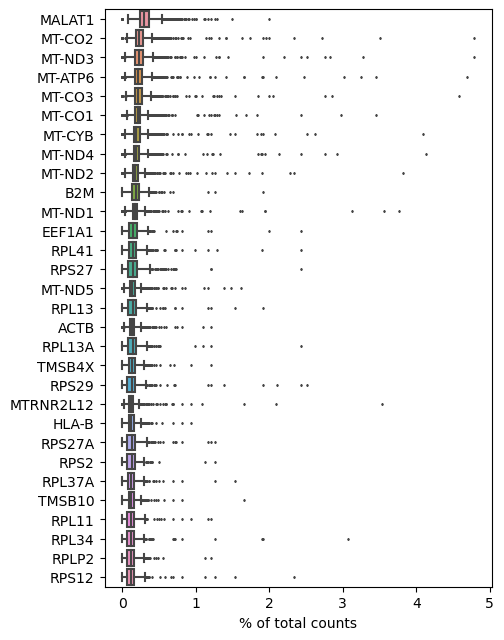

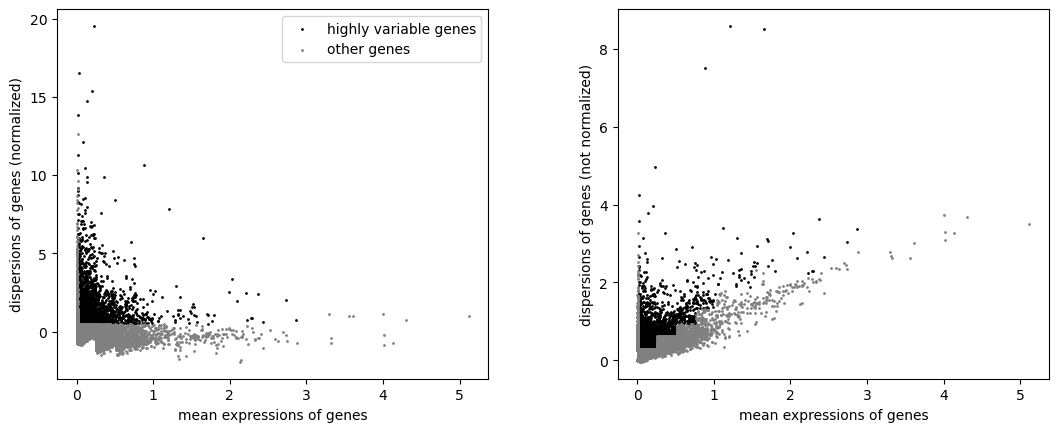

In [5]:
# Unsurprisingly, the most highly expressed genes are MALAT1 and mitochondrial
sc.pl.highest_expr_genes(pbmc)
sc.pl.highly_variable_genes(pbmc)

In [ ]:
# We run the UMAP algorithm for visualization but be cautious interpreting the distances between points
# See, for example: https://www.biorxiv.org/content/10.1101/689851v6
sc.tl.umap(pbmc)

# Regress out cell cycle effects

In [6]:
def check_marker_genes_in_adata(adata, gene_list):
    return [x for x in gene_list if x in adata.var_names]

In [7]:
# The first 43 genes are S phase the others are markers of G2M.
# See here: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb
cc_genes = pd.read_csv('./ref_data/regev_lab_cell_cycle_genes.txt', header=None).T.values[0];
s_genes = cc_genes[:43];
g2m_genes = cc_genes[43:];

cc_genes = check_marker_genes_in_adata(pbmc, cc_genes);
# s_genes = check_marker_genes_in_adata(pbmc, s_genes);
# g2m_genes = check_marker_genes_in_adata(pbmc, g2m_genes);

In [8]:
sc.tl.score_genes_cell_cycle(pbmc, s_genes=s_genes, g2m_genes=g2m_genes)

/Users/jjray/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/jjray/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


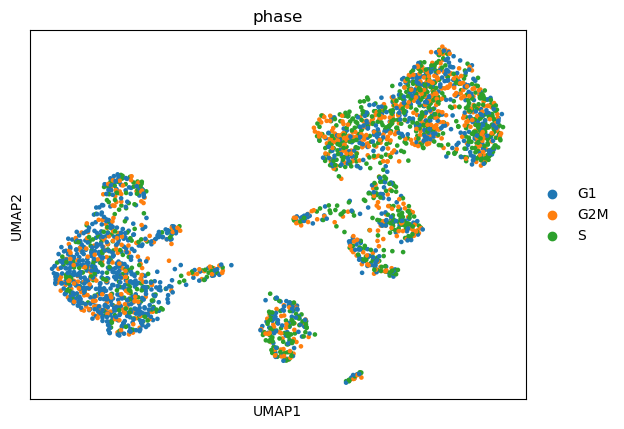

In [11]:
sc.pl.umap(pbmc, color = 'phase')

In [15]:
pbmc_regressed = sc.pp.regress_out(pbmc, ['S_score','G2M_score'], copy=True);

# QC Filtering of Single Nucleus Gene Expression Data

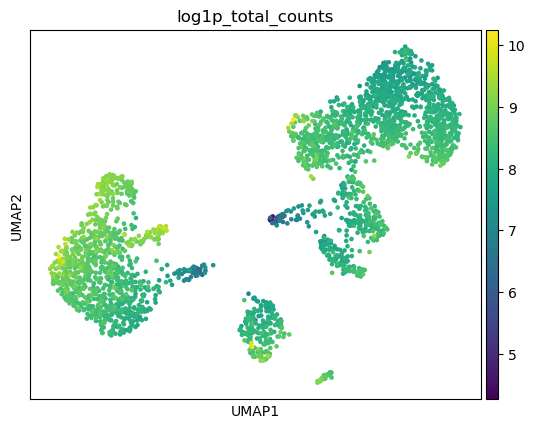

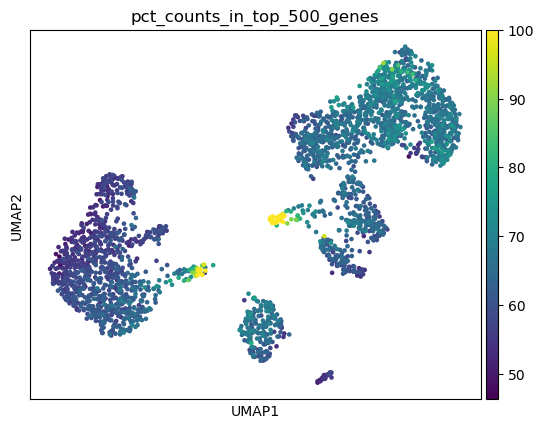

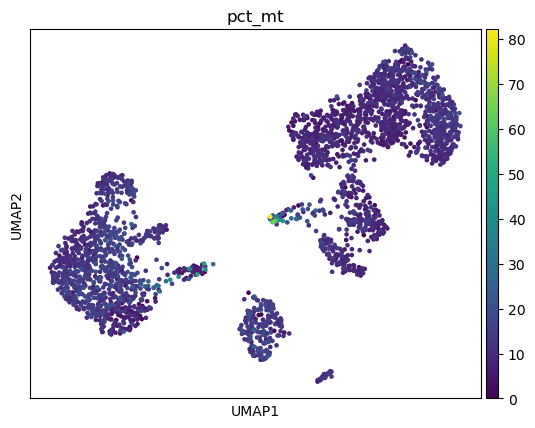

In [50]:
# Quality control metrics suggest that two clusters contain lower quality cells than others
sc.pl.umap(pbmc_regressed, color = 'log1p_total_counts')
sc.pl.umap(pbmc_regressed, color = 'pct_counts_in_top_500_genes')
sc.pl.umap(pbmc_regressed, color = 'pct_mt')

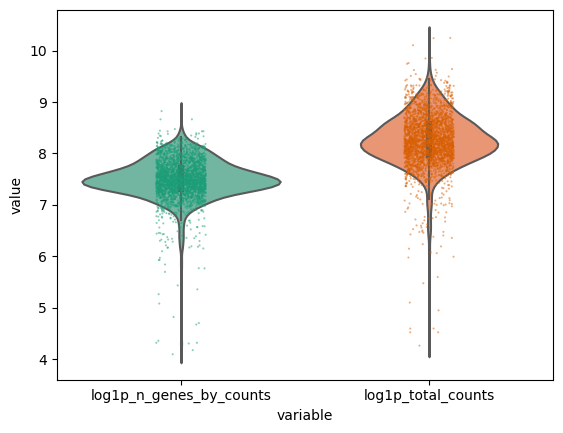

In [17]:
plot_dat = pbmc_regressed.obs.loc[:,['log1p_n_genes_by_counts','log1p_total_counts']];
plot_dat_melt = plot_dat.melt();
sns.violinplot(data=plot_dat_melt, y='value', x='variable', palette='Set2');
sns.stripplot(data=plot_dat_melt, y='value', x='variable', palette='Dark2', alpha=0.5, size=1.5);

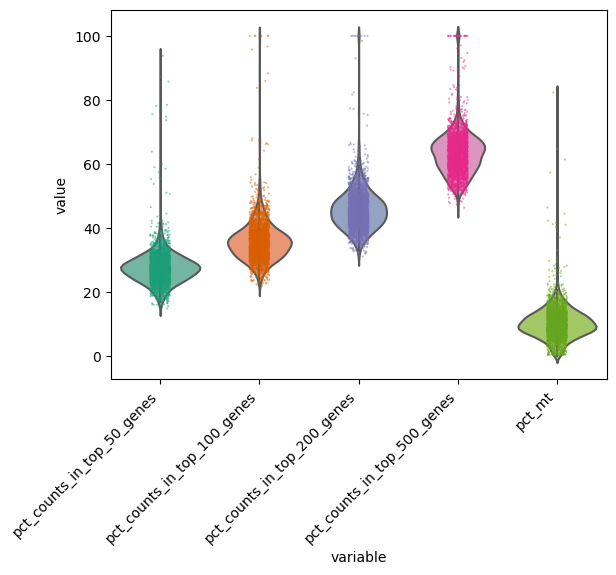

In [18]:
pct_summary_vars = ['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_mt'];
plot_dat = pbmc_regressed.obs.loc[:,pct_summary_vars];
plot_dat_melt = plot_dat.melt();
sns.violinplot(data=plot_dat_melt, y='value', x='variable', palette='Set2');
sns.stripplot(data=plot_dat_melt, y='value', x='variable', palette='Dark2', alpha=0.5, size=1.5);
plt.xticks(rotation=45, ha='right');

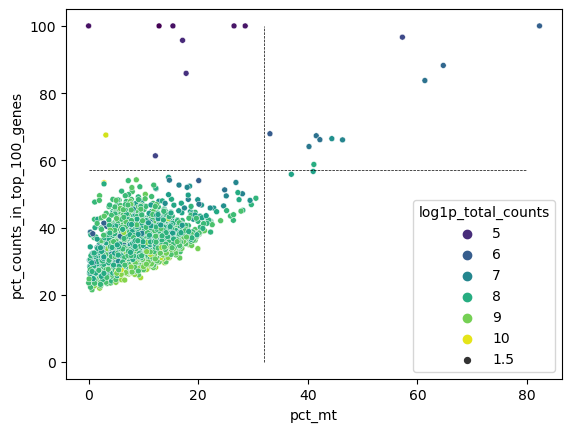

In [19]:
# Applying thresholds in two of the dimensions appears to rid the dataset of the most extreme outliers
pct_summary_vars = ['pct_counts_in_top_100_genes', 'pct_mt', 'log1p_total_counts'];
plot_dat = pbmc_regressed.obs.loc[:,pct_summary_vars];
sns.scatterplot(data=plot_dat, y='pct_counts_in_top_100_genes', x='pct_mt', hue='log1p_total_counts', palette='viridis', size=1.5);
top_100_threshold = 57;
pct_mt_threshold = 32;
plt.hlines(top_100_threshold, 0, 80, linestyles='dashed', linewidths=0.5, colors='k');
plt.vlines(pct_mt_threshold, 0, 100, linestyles='dashed', linewidths=0.5, colors='k');

In [20]:
pbmc_obs_filt = pbmc_regressed.obs.where(pbmc_regressed.obs.loc[:,'pct_mt'].lt(pct_mt_threshold));
pbmc_obs_filt = pbmc_obs_filt.where(pbmc_obs_filt.loc[:,'pct_counts_in_top_100_genes'].lt(top_100_threshold)).dropna();

In [21]:
pbmc_regressed.n_obs

2711

In [22]:
pbmc_qc = pbmc_regressed[pbmc_obs_filt.index].copy();

In [23]:
pbmc_qc.n_obs

2689

# Process scATAC-seq Data

## Load ATAC Data

In [24]:
atac_col = pd.read_csv('./pbmc_3k_archr_csv/pbmc_3k_atac_colData.csv', index_col=0);
atac_emd = pd.read_csv('./pbmc_3k_archr_csv/pbmc_3k_atac_elementMetadata.csv', index_col=0);
atac_gsm = pd.read_csv('./pbmc_3k_archr_csv/pbmc_3k_atac_gene_score_matrix.csv', index_col=0);
atac_umap_coords = pd.read_csv('./pbmc_3k_archr_csv/pbmc_3k_atac_lsi_umap_coords.csv', index_col=0);
atac_imp = pd.read_csv('./pbmc_3k_archr_csv/pbmc_3k_atac_imputed_matrix.csv', index_col=0);

In [25]:
# The column indicating ATAC-based cluster membership has an unfortunate name - let's rename it
atac_col.columns

Index(['BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags',
       'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC',
       'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS',
       'Sample', 'TSSEnrichment',
       'projColData...colnames.projColData...ni..colnames.colData..'],
      dtype='object')

In [26]:
atac_col.columns = ['BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags',
                    'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio',
                    'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment',
                    'ATAC_Cluster'];

## Plot ATAC QC data

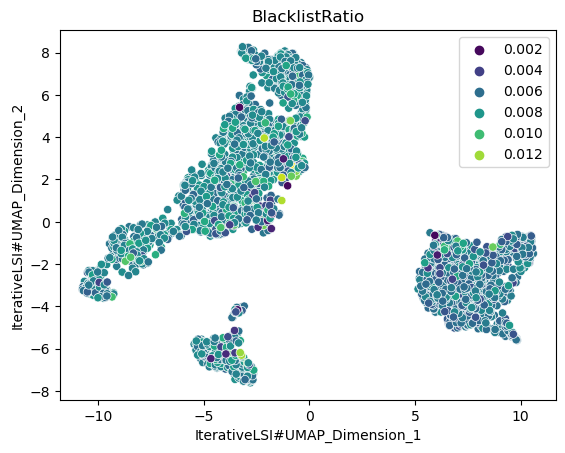

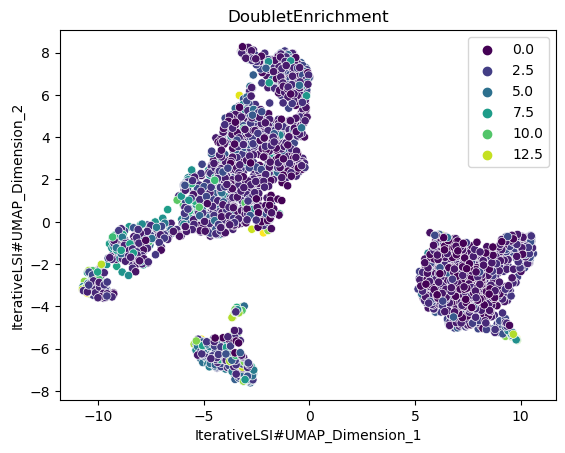

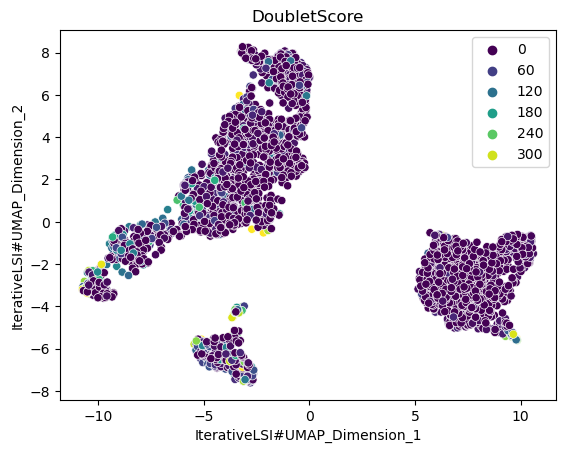

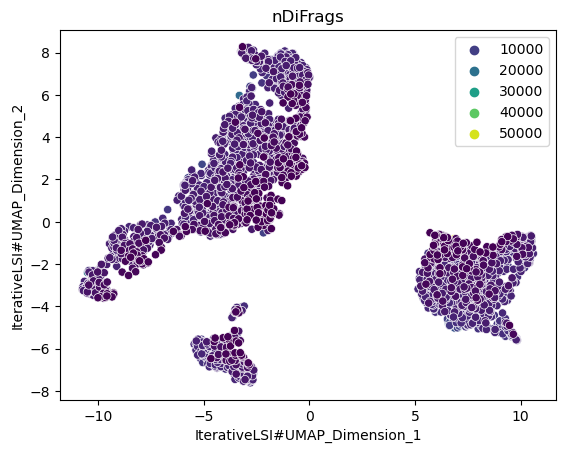

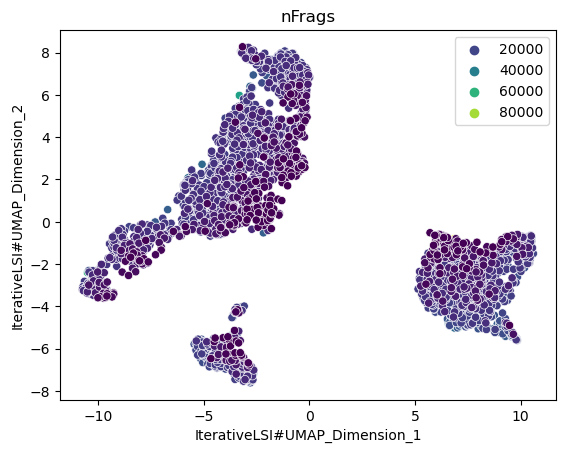

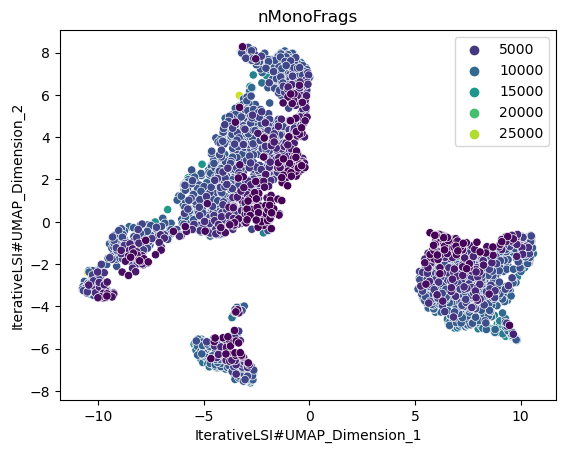

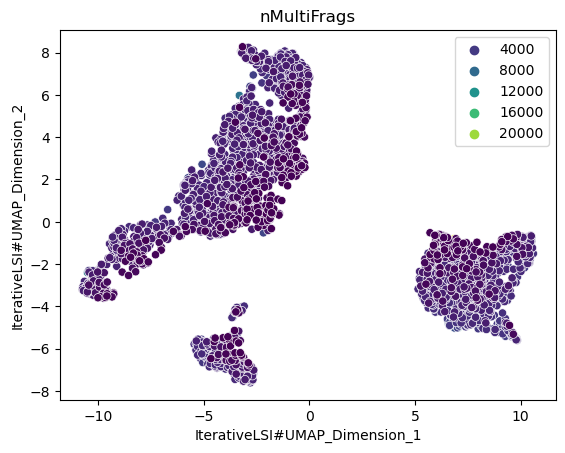

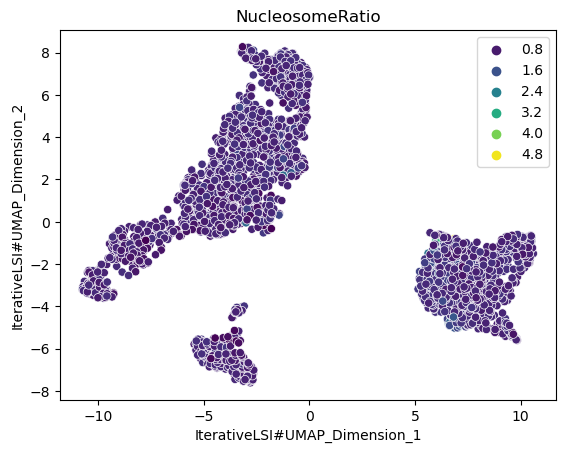

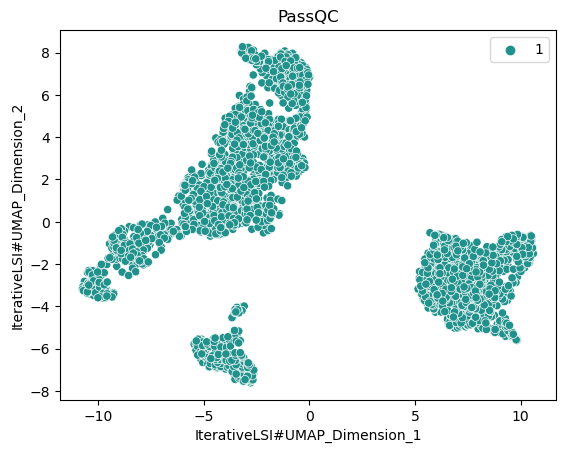

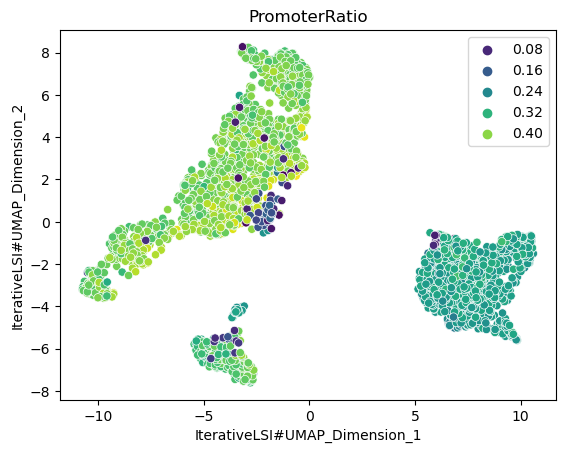

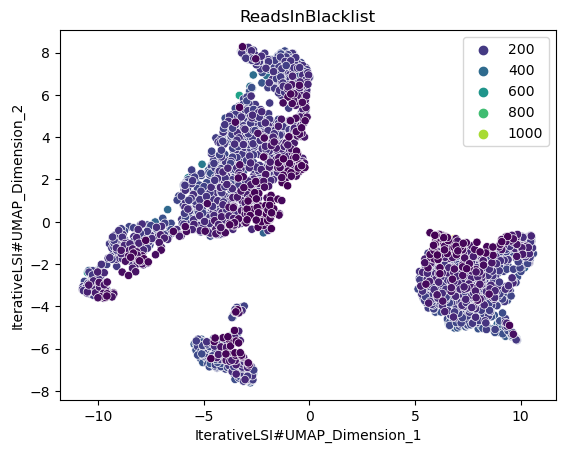

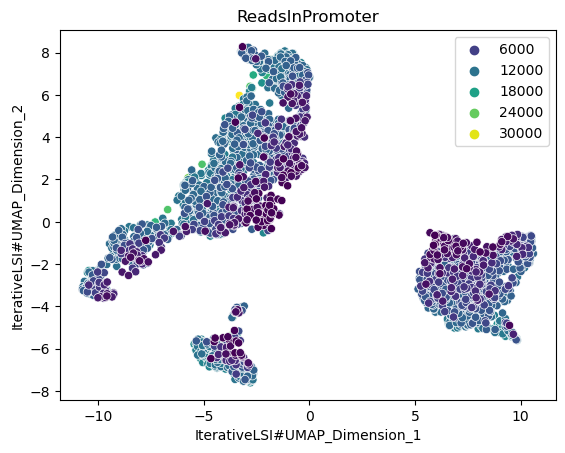

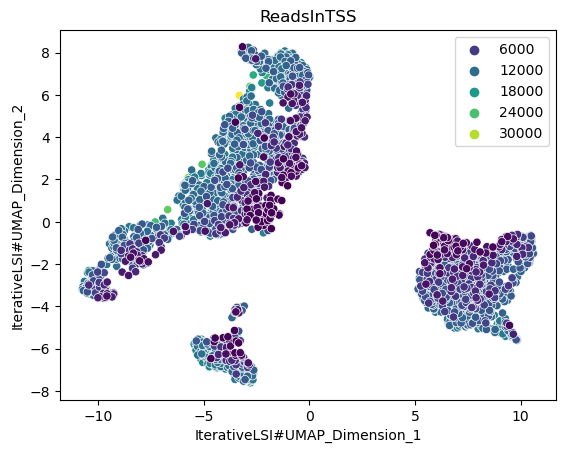

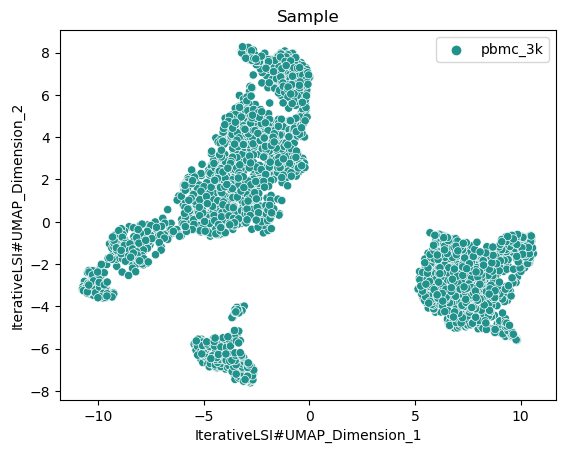

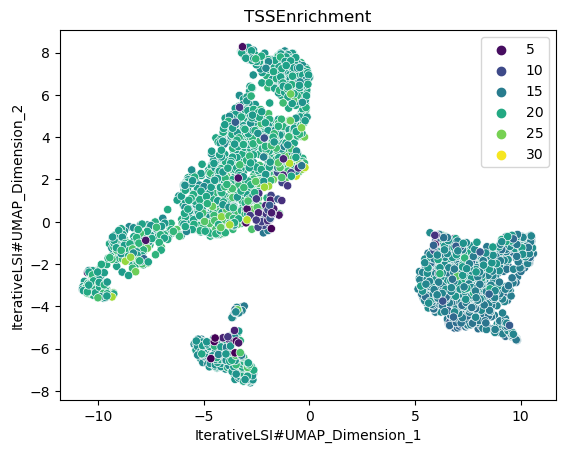

In [53]:
# Plot ATAC-based QC data on the ATAC-based UMAP projection
atac_summary_data = pd.concat([atac_umap_coords,atac_col],axis=1);
for q in atac_col.columns[:-1]:
    f,ax = plt.subplots();
    sns.scatterplot(data=atac_summary_data,y='IterativeLSI#UMAP_Dimension_2', x='IterativeLSI#UMAP_Dimension_1', hue=q, palette='viridis');
    plt.legend(bbox_to_anchor=(1,1));
    plt.title(q);

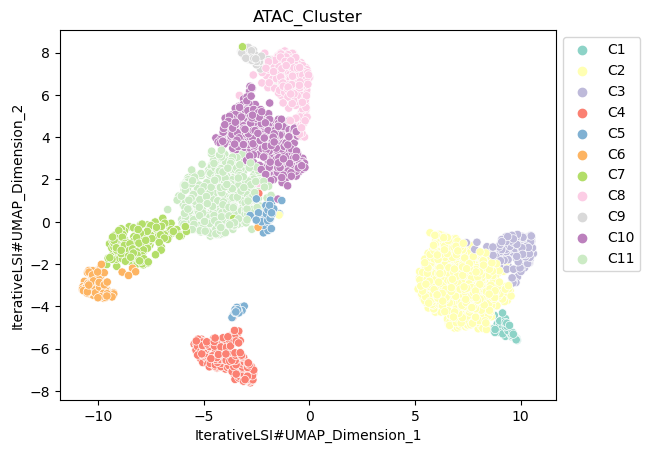

In [29]:
# Same UMAP, colored by ATAC cluster
sorted_clust_names = natsorted(atac_summary_data.loc[:,'ATAC_Cluster'].drop_duplicates().values)
q = 'ATAC_Cluster';
sns.scatterplot(data=atac_summary_data, y='IterativeLSI#UMAP_Dimension_2', x='IterativeLSI#UMAP_Dimension_1', hue=q, palette='Set3', hue_order=sorted_clust_names);
plt.legend(bbox_to_anchor=(1,1));
plt.title(q);

## Explore gene scores from ArchR output

In [ ]:
# Marker genes for immune cells from https://www.archrproject.com/articles/Articles/tutorial.html
marker_genes = [
    "CD34",  # Early Progenitor
    "GATA1", # Erythroid
    "PAX5", "MS4A1", "MME", # B-Cell Trajectory
    "CD14", "MPO", # Monocytes
    "CD3D", "CD8A" # TCells
];

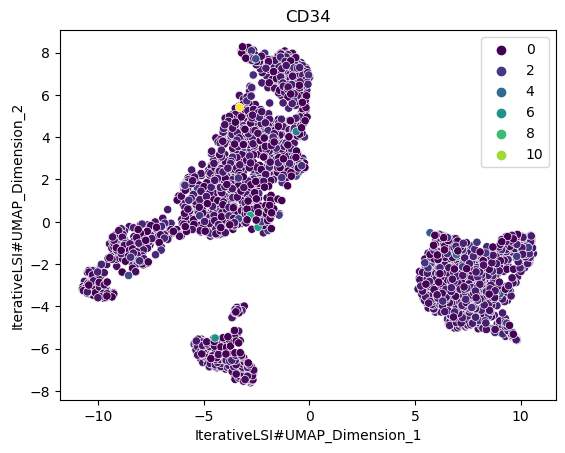

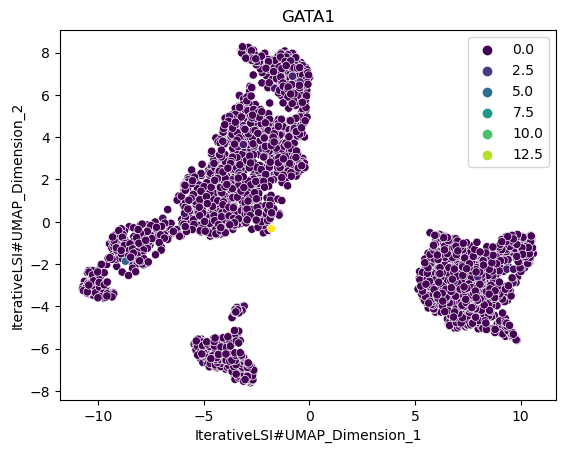

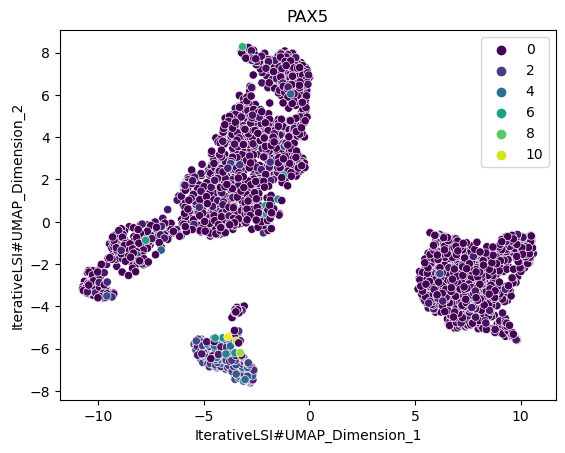

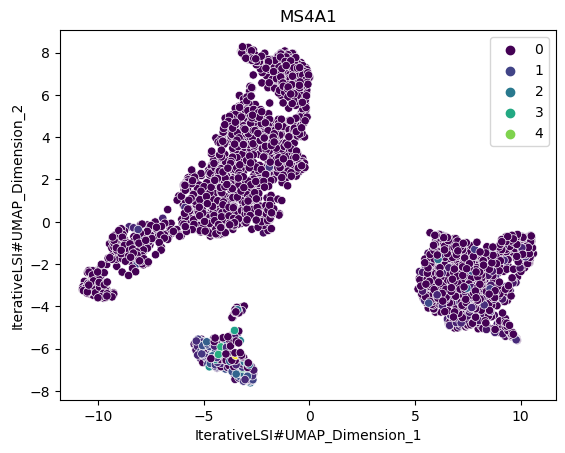

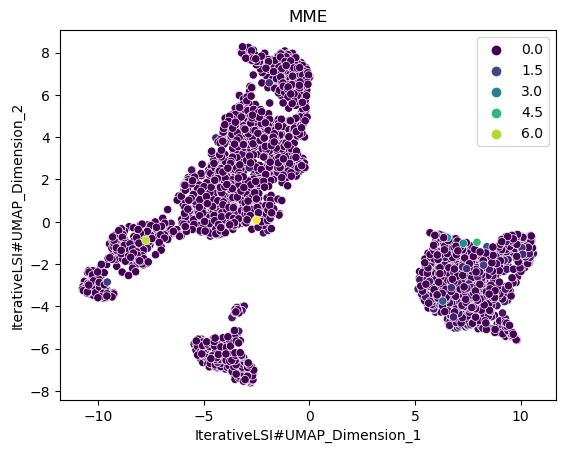

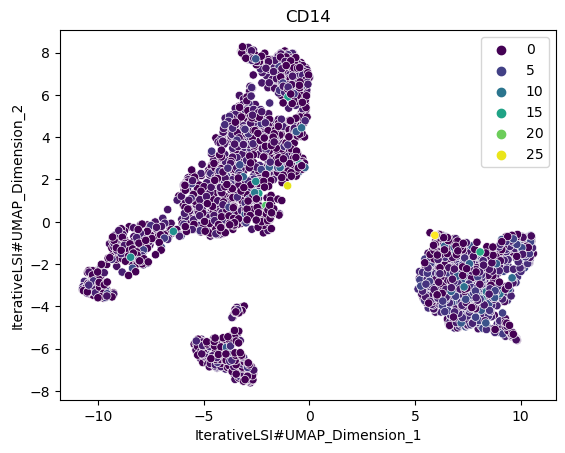

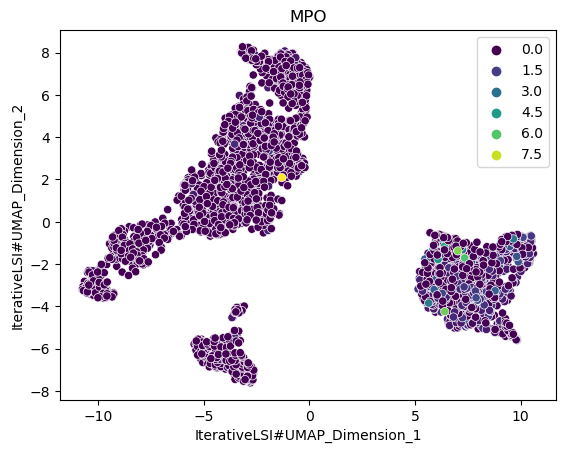

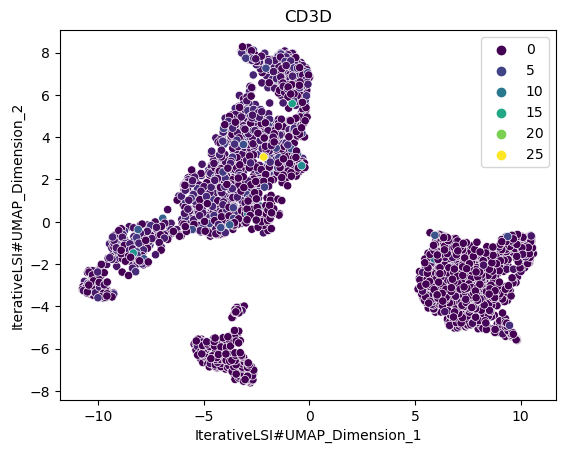

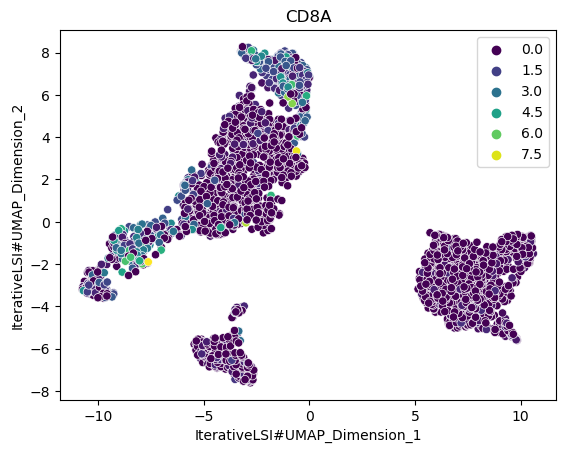

In [32]:
# Raw gene scores without imputation
atac_gscore_data = pd.concat([atac_umap_coords,atac_gsm.T],axis=1);
for q in marker_genes:
    f,ax = plt.subplots();
    sns.scatterplot(data=atac_gscore_data,y='IterativeLSI#UMAP_Dimension_2', x='IterativeLSI#UMAP_Dimension_1', hue=q, palette='viridis');
    plt.legend(bbox_to_anchor=(1,1));
    plt.title(q);

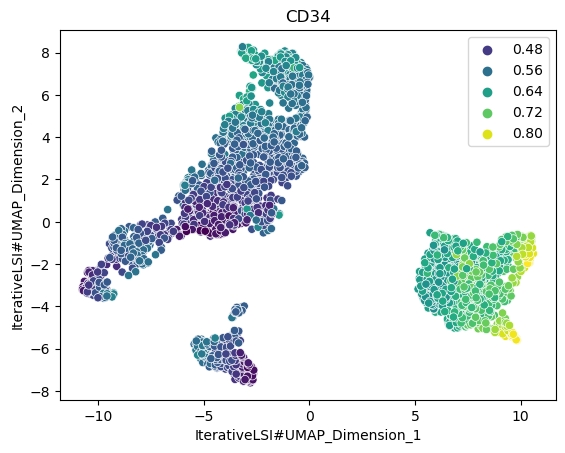

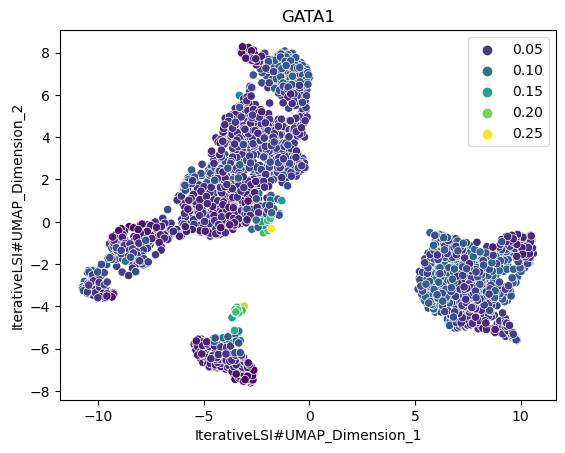

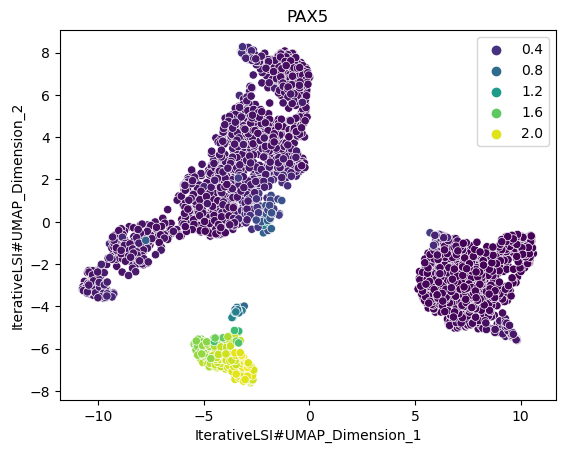

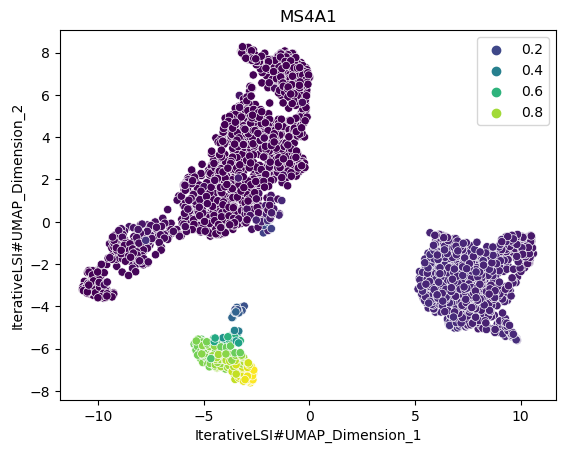

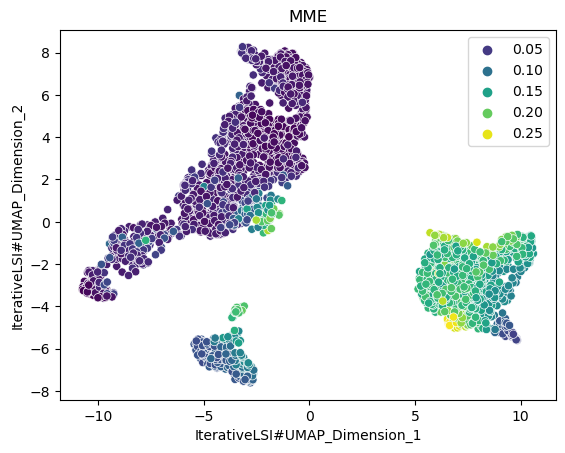

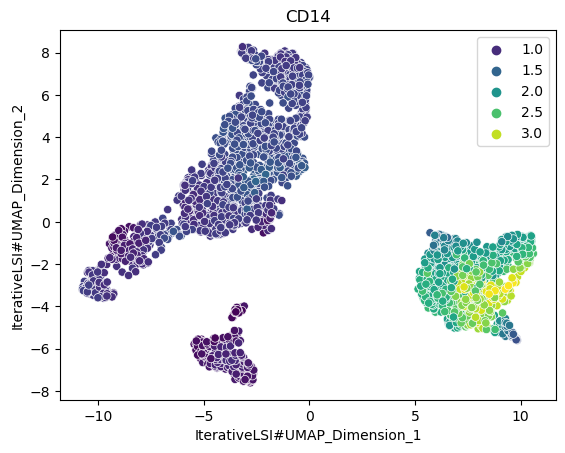

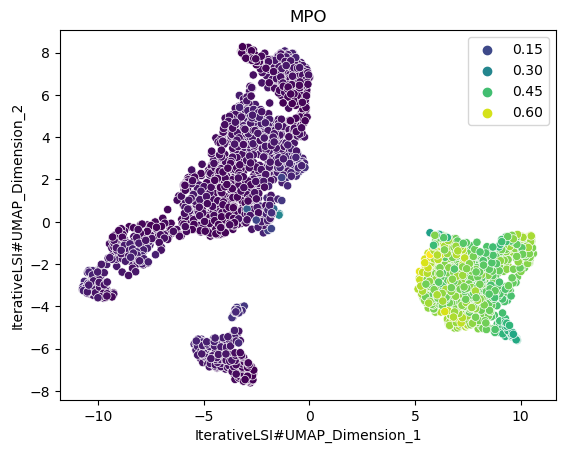

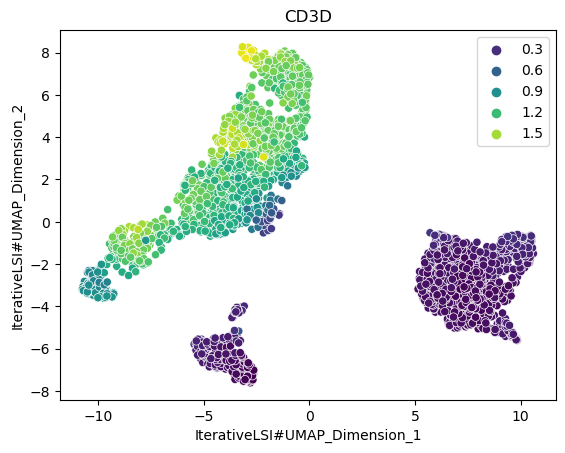

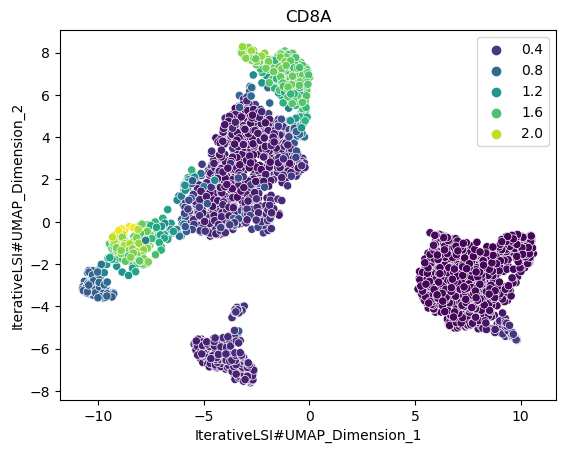

In [34]:
# Gene scores with imputation
atac_imp_data = pd.concat([atac_umap_coords,atac_imp.T],axis=1);
for q in marker_genes:
    f,ax = plt.subplots();
    sns.scatterplot(data=atac_imp_data,y='IterativeLSI#UMAP_Dimension_2', x='IterativeLSI#UMAP_Dimension_1', hue=q, palette='viridis');
    plt.legend(bbox_to_anchor=(1,1));
    plt.title(q);

# scATAC comparison to snGEXP in the same nuclei - Preprocessing

## Subset cells and genes to those present and passing QC in both modalities

In [35]:
# Rename cells in the gene expression object to have experimental rep name prepended
# This will make cell IDs match ArchR output
gexp_index = pd.Index(['pbmc_3k#'+q for q in pbmc_qc.obs.index]);
pbmc_qc.obs.index = gexp_index

In [36]:
keep_cells = atac_col.index.intersection(gexp_index);

pbmc_filt = pbmc_qc[keep_cells];

gexp_umap_coords_filt = pd.DataFrame(data=pbmc_filt.obsm['X_umap'], index=pbmc_filt.obs.index, columns=['GEXP_UMAP1','GEXP_UMAP2']);
atac_umap_coords_filt = atac_umap_coords.loc[keep_cells];

atac_col_filt = atac_col.loc[keep_cells];
atac_emd_filt = atac_emd;
atac_gsm_filt = atac_gsm.loc[:,keep_cells];
atac_imp_filt = atac_imp.loc[:,keep_cells];

In [37]:
keep_genes = pd.Index(atac_emd_filt.loc[:,'name']).intersection(pbmc_filt.var.index);

pbmc_filt = pbmc_filt[:,keep_genes];

atac_emd_filt = atac_emd_filt.where(atac_emd_filt.loc[:,'name'].isin(keep_genes)).dropna();
atac_gsm_filt = atac_gsm_filt.loc[keep_genes];
atac_imp_filt = atac_imp_filt.loc[keep_genes];

## Plotting Helper Functions

In [38]:
sorted_clust_names = natsorted(atac_summary_data.loc[:,'ATAC_Cluster'].drop_duplicates().values);

def modal_rel_scatterplot(marker_case, x_scores, y_scores, hue_scores, hue_order=sorted_clust_names, x_name='Imputed ATAC Score', y_name='Normed Expression Level', hue_name='ATAC_Cluster', palette='Set3', point_size=1.5):
    ''' This automates plotting across modes in single-cell gene expression data,
        for example ATAC versus gene expression. x_scores & hue_scores should be
        Pandas DataFrames; y_scores should be an AnnData object. '''
    
    gene_score_case = pd.concat([hue_scores.loc[:,hue_name], x_scores.loc[marker_case], y_scores[:,marker_case].to_df()],axis=1);
    gene_score_case.columns = [hue_name, x_name, y_name];
    
    f,ax = plt.subplots(figsize=(5,3));
    sns.scatterplot(data=gene_score_case, x=x_name, y=y_name, hue=hue_name, palette=palette, hue_order=sorted_clust_names);
    plt.legend(bbox_to_anchor=(1,1), title=hue_name);
    plt.title(marker_case);

In [39]:
def color_umap(umap_coords, hue_data, title=None, palette='viridis', point_size=1.5):
    ''' Take a dataframe with UMAP coordinates and concat it with a dataframe
        having the same row names containing data for coloring the UMAP. '''
    
    plot_dat = pd.concat([umap_coords,hue_data],axis=1);
    
    f,ax = plt.subplots();
    sns.scatterplot(data=plot_dat, x=plot_dat.columns[0], y=plot_dat.columns[1], hue=plot_dat.columns[2], palette=palette, size=point_size);
    plt.title(title);

In [40]:
def scan_markers_scatter(marker_list, x_scores=atac_imp_filt, y_scores=pbmc_filt, hue_scores=atac_col_filt):
    marker_not_present = [];
    for marker_case in marker_list:
        if np.any(x_scores.index.values == marker_case):
            modal_rel_scatterplot(marker_case, x_scores=x_scores, y_scores=y_scores, hue_scores=hue_scores);
        else:
            marker_not_present.append(marker_case);
    if len(marker_not_present) > 0:
        print('Markers not in dataset:\t', marker_not_present)

# Immune Cell Marker Analysis

In this section, we look up a selection of established markers for various immune cell subtypes and compare their gene expression to their imputed ATAC-based gene scores.
The markers are explained here: https://www.cellsignal.com/pathways/immune-cell-markers-human

The conclusion that we can draw from this is how gene expression states of many of the classical markers perform at distinguishing cell states or types.

## Comparing invidual markers of lineages between ATAC/gene expression modes

In [41]:
# Myeloid lineage markers
markers_myeloid = ['ITGAM']; # aka CD11b
markers_hla = ['HLA-DRA','HLA-DRB1', 'HLA-DRB2', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-DQA1', 'HLA-DQB1'];

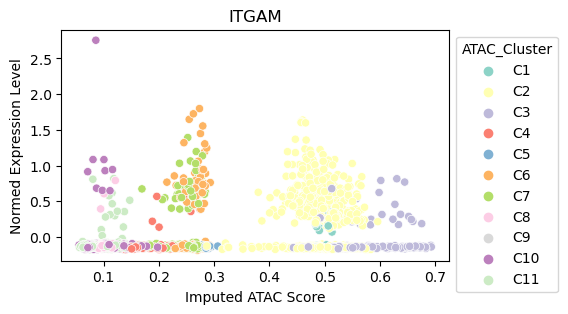

In [42]:
# Note the high number of zeroes in the gene expression data - this is dropouts
# scATAC-seq has dropouts as well, but this is showing the IMPUTED gene scores
# That means the ATAC-based gene scores are statistical estimates based on properties
# of the surrounding genome compared to similar cells, not raw scores.
marker_list = markers_myeloid;
scan_markers_scatter(marker_list)

Markers not in dataset:	 ['HLA-DRB2', 'HLA-DRB3', 'HLA-DRB4']


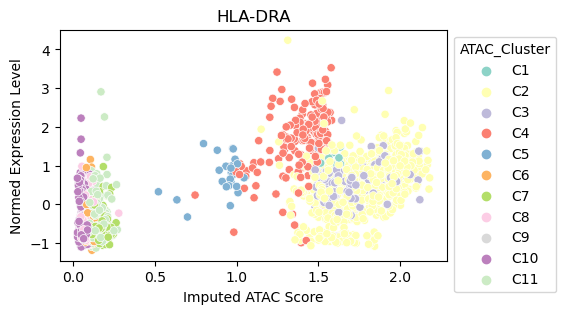

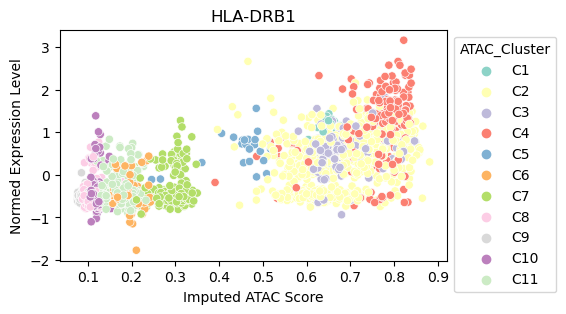

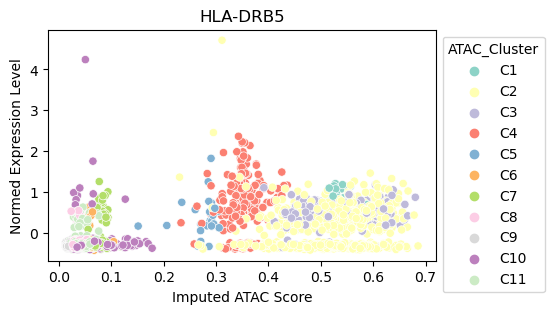

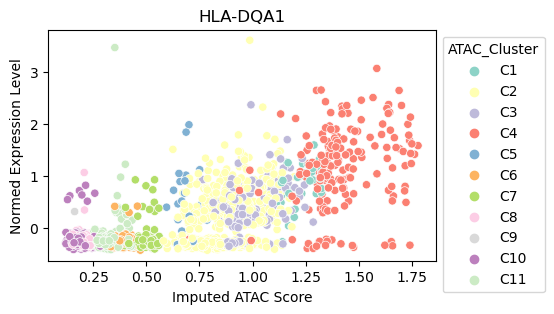

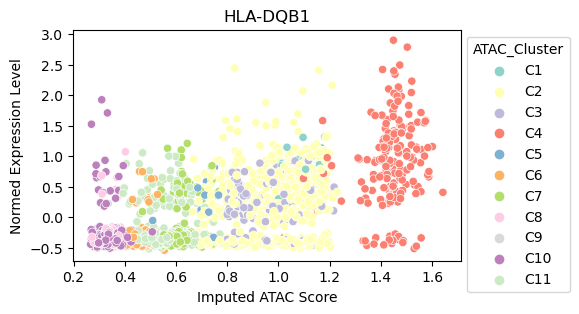

In [43]:
marker_list = markers_hla;
scan_markers_scatter(marker_list)

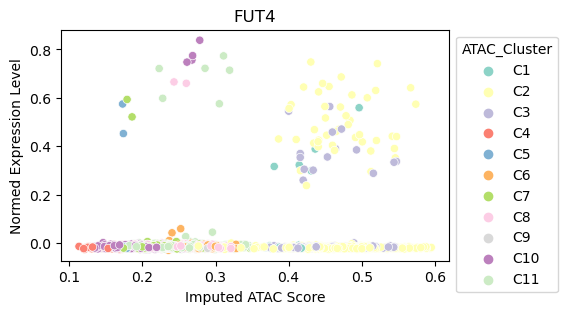

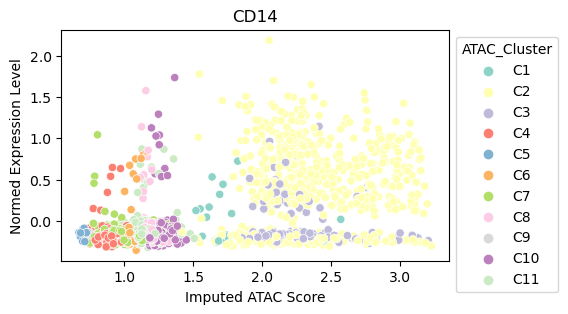

In [55]:
# MDSC markers
marker_list = [
    'FUT4', #CD15
    'CD14'];

scan_markers_scatter(marker_list)

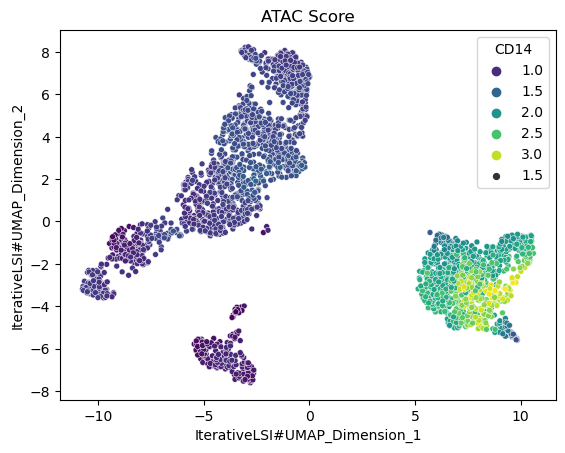

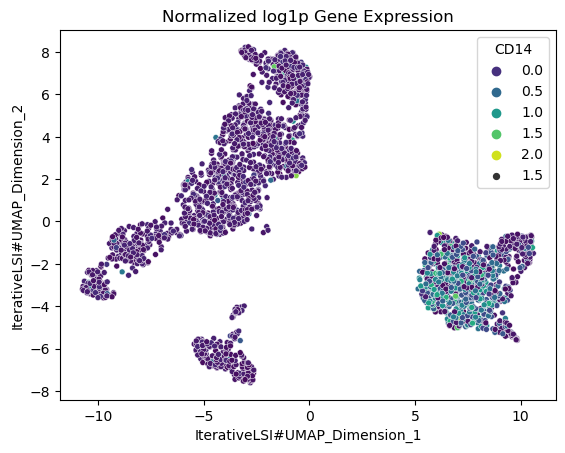

In [45]:
marker_case = 'CD14';
color_umap(atac_umap_coords_filt, atac_imp_filt.loc[marker_case], title='ATAC Score');

marker_case = 'CD14';
color_umap(atac_umap_coords_filt, pbmc_filt[:,marker_case].to_df(), title='Normalized log1p Gene Expression');

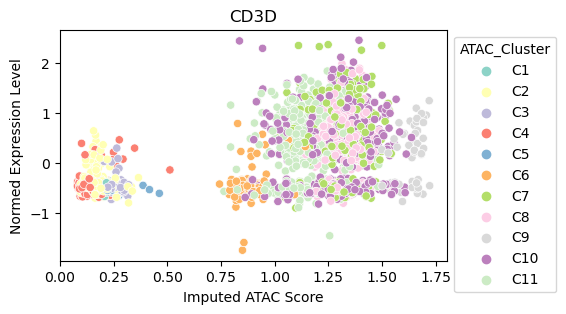

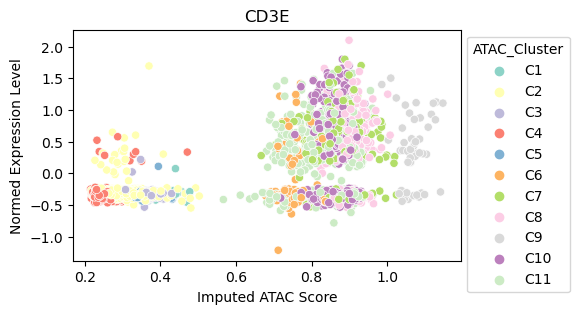

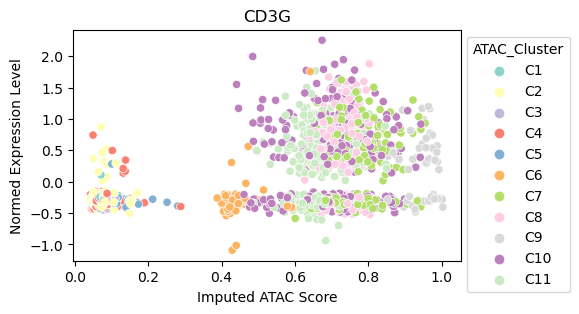

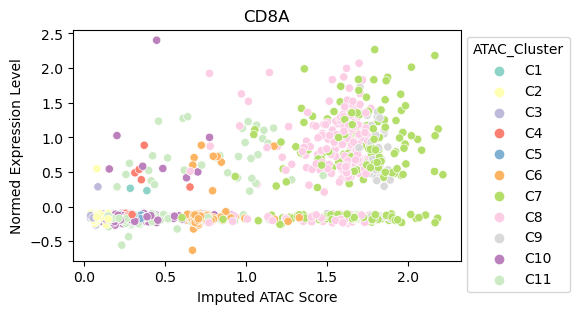

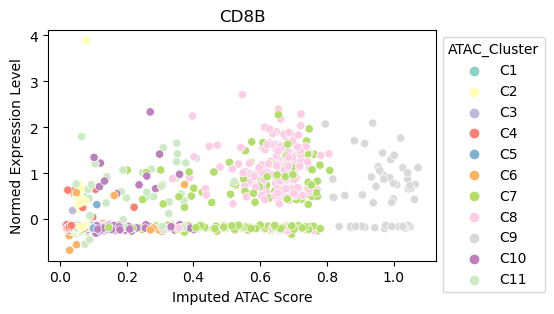

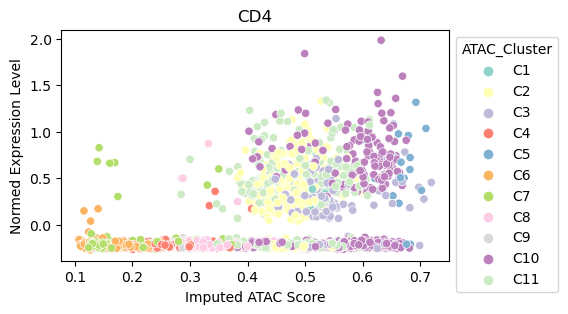

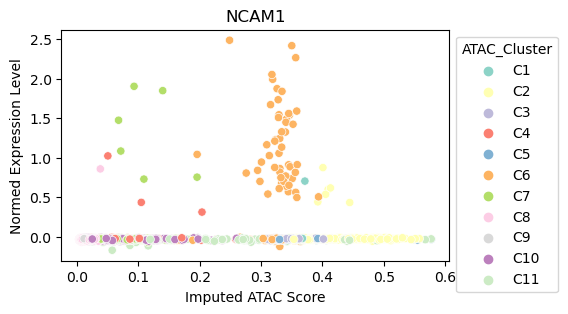

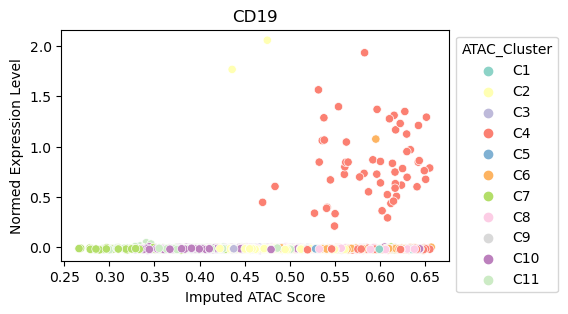

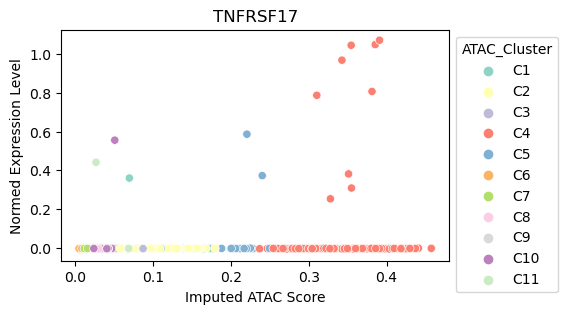

In [46]:
# T Cell Markers
marker_list = [
    'CD3D',
    'CD3E',
    'CD3G',
    'CD8A',
    'CD8B',
    'CD4',
    'NCAM1', # 'CD56',
    'CD19',
    'TNFRSF17'
];

scan_markers_scatter(marker_list)

## Comparison of ATAC scores for a classic marker pair

Individual markers are interesting, but the ability to link them together in the same cell is what makes single-cell omics data shine. Here we explore combinations of T cell and myeloid markers.

First, let's annotate the coarse clusters using individual markers.

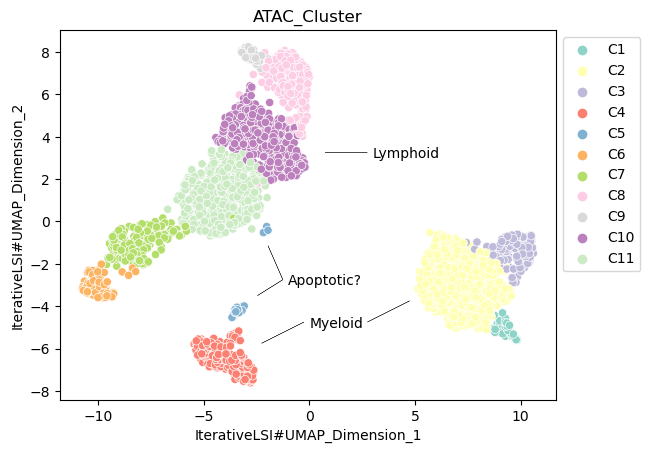

In [95]:
# First, let's revisit and annotate the putative major
# lineages of the ATAC clusters based on individual markers
# C1, C2, C3, and C4 are generally high in HLA and lower in T cell markers - possibly myeloid.
# C5 is similar to the low-quality cells filtered out. They may be approaching apoptosis.
# C6, C7, C8, C9, C10, and C11 have T cell markers but lower scores for HLA. Possibly lymphoid.
atac_summary_data = pd.concat([atac_umap_coords_filt,atac_col_filt],axis=1);
sorted_clust_names = natsorted(atac_summary_data.loc[:,'ATAC_Cluster'].drop_duplicates().values)
q = 'ATAC_Cluster';
sns.scatterplot(data=atac_summary_data,
                y='IterativeLSI#UMAP_Dimension_2',
                x='IterativeLSI#UMAP_Dimension_1',
                hue=q, palette='Set3', hue_order=sorted_clust_names);
plt.legend(bbox_to_anchor=(1,1));
plt.title(q);

# This just draws the annotations
plt.text(-1, -3, 'Apoptotic?');
plt.arrow(-1.25,-2.75,-0.7,1.6, linewidth = 0.25);
plt.arrow(-1.25,-2.75,-1.2,-0.75, linewidth = 0.25);
plt.text(0, -5, 'Myeloid');
plt.arrow(-0.25,-4.75,-2,-1, linewidth = 0.25);
plt.arrow(2.75,-4.75,2,1, linewidth = 0.25);
plt.text(3, 3, 'Lymphoid');
plt.arrow(2.75,3.25,-2,0, linewidth = 0.25);

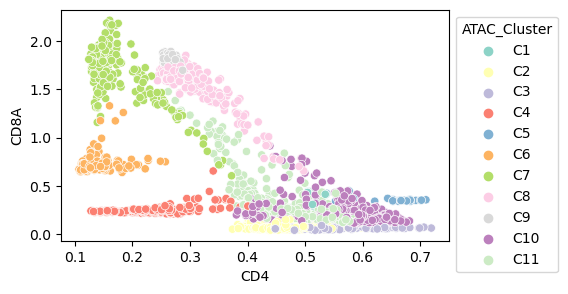

In [57]:
# Within the lymphoid lineage, there are clear subpopulations of 
# CD4+/CD8- T helper cells (members of C7)
# CD4-/CD8+ cytotoxic T cells (members of C10)
# and other cells types that will require different marker combinations to identify.
marker_x = 'CD4';
marker_y = 'CD8A';
hue_scores = atac_col_filt;
hue_name = 'ATAC_Cluster';
gene_score_case = pd.concat([hue_scores.loc[:,hue_name], atac_imp_filt.loc[marker_x], atac_imp_filt.loc[marker_y]],axis=1);
gene_score_case.columns = [hue_name, marker_x, marker_y];

f,ax = plt.subplots(figsize=(5,3));
sns.scatterplot(data=gene_score_case, x=marker_x, y=marker_y, hue=hue_name, palette='Set3', hue_order=sorted_clust_names);
plt.legend(bbox_to_anchor=(1,1), title=hue_name);